In [1]:
knitr::opts_chunk$set(echo = TRUE)

library(dplyr)
library(ggplot2)
library(tidyr)
library(kableExtra)
library(lmtest)
library(car)
library(UpSetR)

source("/Users/kevin_li/Desktop/UCSD Grad School Books/Winter 2024/FMPH 222/Homework/hoslemv2.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




In [2]:
df_all <- read.csv(
    "/Users/kevin_li/Desktop/UCSD Grad School Books/Winter 2024/FMPH 222/Project/HPS_Week17_PUF_CSV/pulse2020_puf_17.csv")

In [3]:
head(df_all)

,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,⋯,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,V170000001S10010610000121,17,49,NA,4,734.0433,2828.458,1954,2,2,⋯,-88,-88,-88,-88,-88,-88,-88,-88,-88,6
2,V170000001S37010120700111,17,1,NA,2,1039.2363,2063.999,1982,2,2,⋯,-88,-88,-88,-88,-88,-88,-88,-88,-88,4
3,V170000001S37010286600121,17,1,NA,2,7236.0991,7185.709,1950,2,2,⋯,-88,-88,-88,-88,-88,-88,-88,-88,-88,2
4,V170000001S37010296700121,17,1,NA,2,2147.1766,4264.448,1988,2,2,⋯,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88
5,V170000001S37010514600111,17,1,NA,2,2496.4173,4958.066,1983,2,1,⋯,-99,-99,-99,1,-99,-99,-99,-99,-99,5
6,V170000001S37010680700121,17,1,NA,2,790.0870,1569.170,1938,2,1,⋯,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88


In [4]:
df <- mutate(df_all, age = 2023-TBIRTH_YEAR) %>%
  mutate(ANXIOUS = ifelse(ANXIOUS < 1, 0, ANXIOUS)) %>%
  mutate(WORRY = ifelse(WORRY < 1, 0, WORRY)) %>%
  mutate(INTEREST = ifelse(INTEREST < 1, 0, INTEREST)) %>%
  mutate(DOWN = ifelse(DOWN < 1, 0, DOWN)) %>%
  mutate(mental_health_score = rowSums(pick(ANXIOUS,WORRY,INTEREST,DOWN))) %>%
  mutate(issue = ifelse(mental_health_score<=4, 0, 1)) %>%
  mutate(age_group = case_when(
    age < 30 ~ "20-29",
    age < 40 & age > 29 ~ "30-39",
    age < 50 & age > 39 ~ "40-49",
    age < 60 & age > 49 ~ "50-59",
    age < 70 & age > 59 ~ "60-69",
    age < 80 & age > 69 ~ "70-79",
    age > 79 ~ "80+"
  )) %>%
  mutate(TW_START = as.character(TW_START)) %>%
  mutate(school_children = ifelse(ENROLL1 ==1 | ENROLL2==1, T, F))

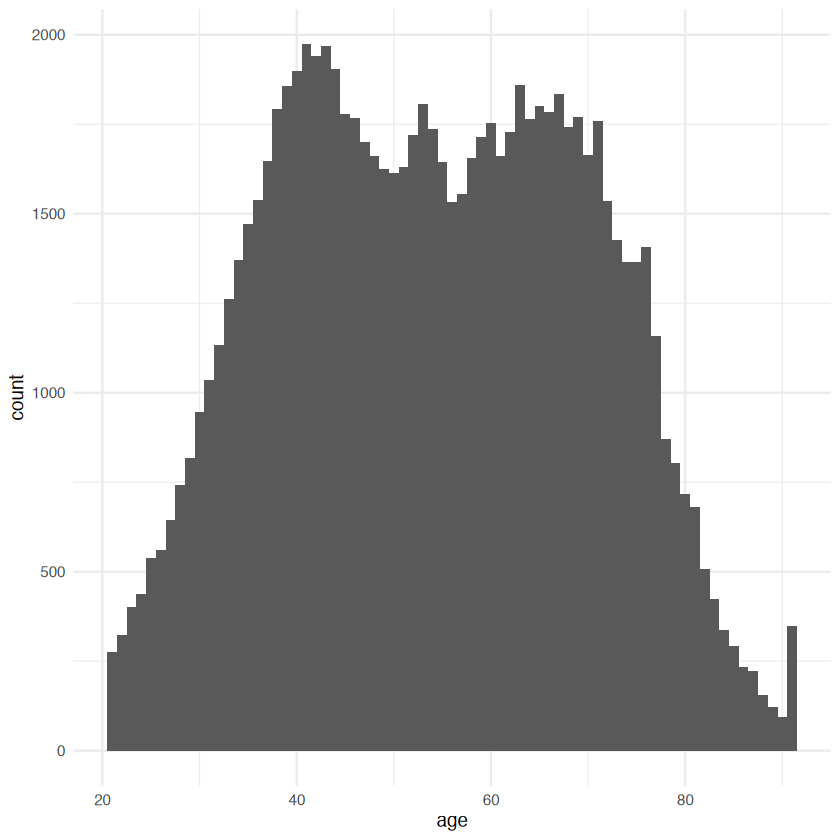

In [5]:
ggplot(df, aes(age)) +
  geom_bar() +
  theme_minimal()

avg_age <- mean(df$age)
median_age <- median(df$age)

`summarise()` has grouped output by 'issue', 'age_group'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


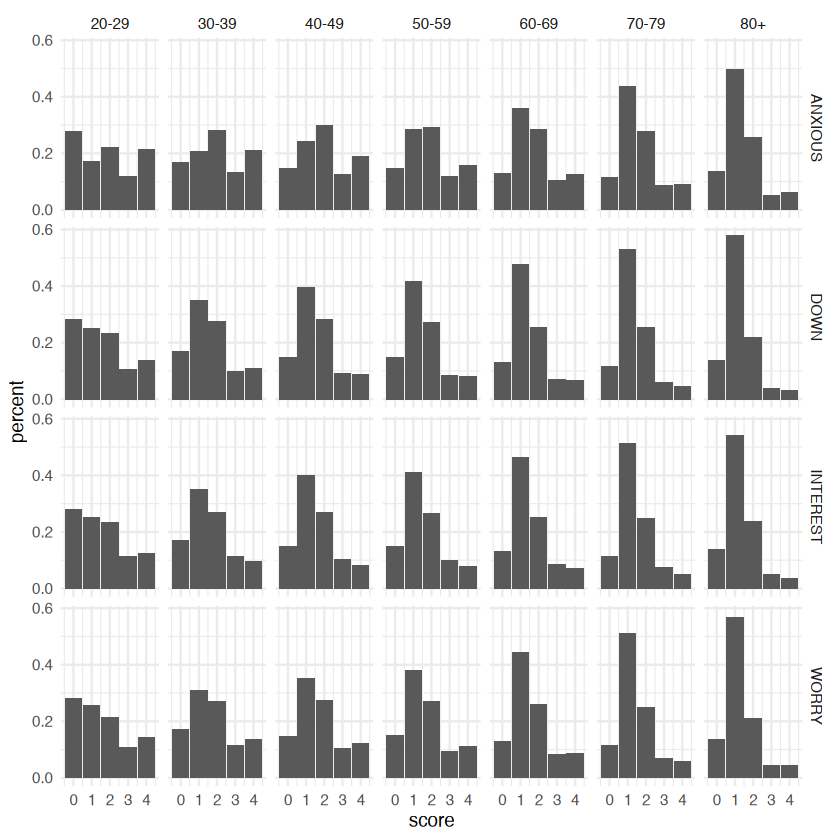

In [6]:
df_mental_health <- select(df, ANXIOUS, WORRY, INTEREST, DOWN, age) %>%
  pivot_longer(cols = c(ANXIOUS,WORRY,INTEREST,DOWN), names_to ="issue", values_to = "score") %>%
  mutate(age_group = case_when(
    age < 30 ~ "20-29",
    age < 40 & age > 29 ~ "30-39",
    age < 50 & age > 39 ~ "40-49",
    age < 60 & age > 49 ~ "50-59",
    age < 70 & age > 59 ~ "60-69",
    age < 80 & age > 69 ~ "70-79",
    age > 79 ~ "80+"
  ))

df_groups <- group_by(df_mental_health, issue, age_group, score) %>%
  summarise(total_issue_age_score = n())

df_groups_age_group_total_score <-  group_by(df_mental_health, age_group, issue) %>%
  summarise(total_issue_age = n())

df_groups <- merge(df_groups, df_groups_age_group_total_score) %>%
  mutate(percent = total_issue_age_score/total_issue_age)

ggplot(df_groups, aes(x=score, y = percent)) +
  geom_col() +
  facet_grid(issue~age_group) +
  theme_minimal()

`summarise()` has grouped output by 'issue'. You can override using the
`.groups` argument.


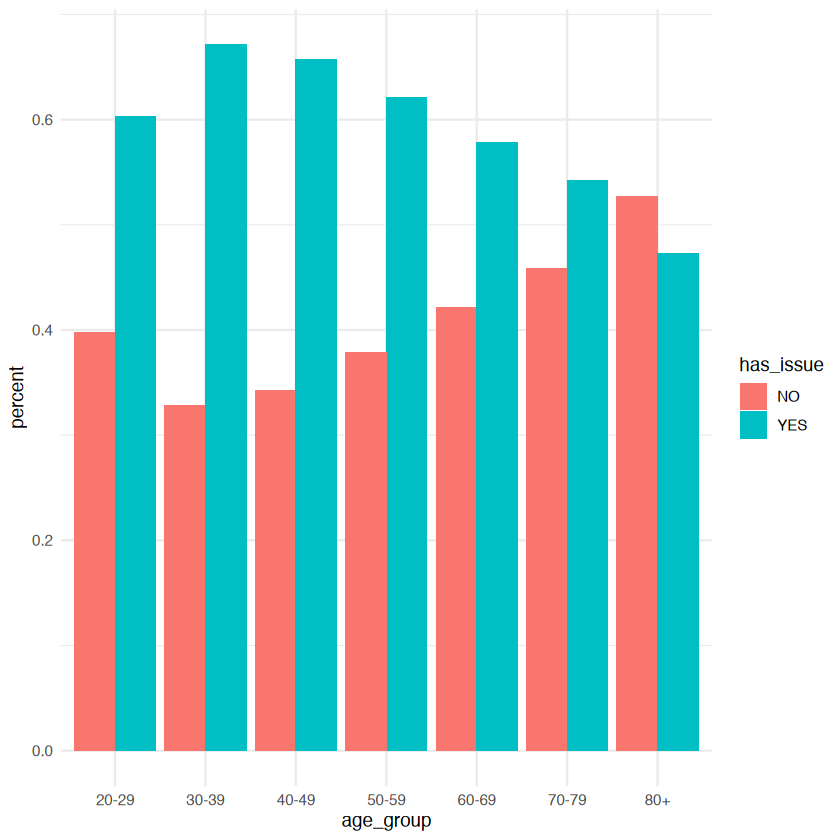

In [7]:
df_groups_y_n_issue <- group_by(df, issue, age_group) %>%
  summarise(total_issue_age_score = n())

df_groups_age_group <-  group_by(df, age_group) %>%
  summarise(total_age_group = n())

df_groups <- merge(df_groups_y_n_issue, df_groups_age_group) %>%
  mutate(percent = total_issue_age_score/total_age_group)%>%
  mutate(has_issue = ifelse(issue ==1, "YES", "NO"))

ggplot(df_groups, aes(x=age_group, y = percent, fill = has_issue)) +
  geom_col(position="dodge") +
  theme_minimal()

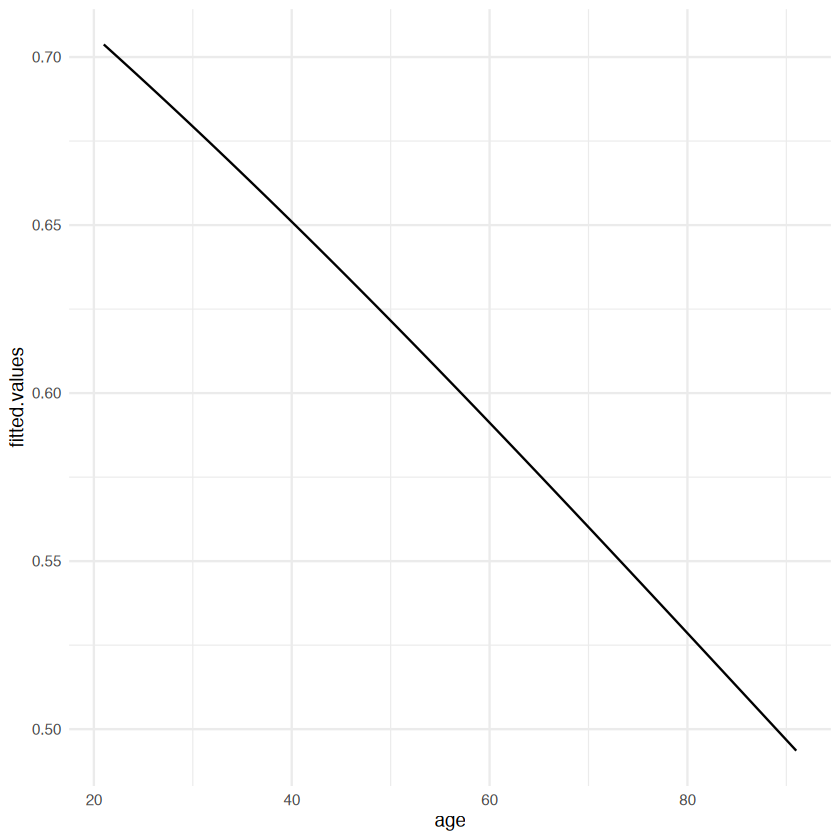

In [8]:
mod.fit <- glm(formula = issue ~ age, family = binomial(link = logit), data = df)

df$fitted.values <- mod.fit$fitted.values

ggplot(df, aes(x = age, y = fitted.values)) +
  geom_line() +
  theme_minimal()

In [9]:
education_level <- select(df,EEDUC) %>% 
  mutate(EEDUC = as.character(EEDUC)) %>%
  group_by(EEDUC) %>%
  summarise(total = n())

tele_work <- select(df,TW_START) %>% 
  mutate(TW_START = as.character(TW_START)) %>%
  group_by(TW_START) %>%
  summarise(total = n()) %>%
  mutate(percent = paste0(round(total/nrow(df),2)*100,"%"))

In [10]:
df_activity <- select(df,FEWRTRANS,PLNDTRIPS,CNCLDTRPS,TW_START,CHNGHOW1,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,CHNGHOW7,CHNGHOW8,CHNGHOW9,CHNGHOW10,CHNGHOW11,CHNGHOW12)
  
df_change <- select(df, starts_with("CHNGHOW"))

df_change[df_change == -99] <- 0
df_change[df_change == -88] <- 0

df_total_change <- colSums(df_change)

df_change <- data.frame(category = colnames(df_change), total =colSums(df_change)) %>%
  mutate(total = as.numeric(total)) %>%
  mutate(percentage = total/nrow(df_change)) %>%
  mutate(percent = paste0(round(percentage, 2)*100, "%"))

kable(select(df_change, category, percent), row.names = F)



|category  |percent |
|:---------|:-------|
|CHNGHOW1  |51%     |
|CHNGHOW2  |26%     |
|CHNGHOW3  |7%      |
|CHNGHOW4  |36%     |
|CHNGHOW5  |3%      |
|CHNGHOW6  |54%     |
|CHNGHOW7  |9%      |
|CHNGHOW8  |26%     |
|CHNGHOW9  |25%     |
|CHNGHOW10 |8%      |
|CHNGHOW11 |3%      |
|CHNGHOW12 |20%     |

In [11]:
df <- mutate(df, changed_shopping_habits_online = ifelse(CHNGHOW1 == 1, 1, 0)) %>%
  mutate(changed_shopping_habits_curbside = ifelse(CHNGHOW2 == 1, 1, 0)) %>%
  mutate(changed_restaurants = ifelse(CHNGHOW6 == 1, 1, 0)) %>%
  mutate(changed_appointments = ifelse(CHNGHOW8 == 1, 1, 0)) %>%
  mutate(changed_caregiving = ifelse(CHNGHOW10 == 1, 1, 0)) %>%
  mutate(total_changed = rowSums(select(.,starts_with("changed")))) %>%
  mutate(changed_bin = total_changed >0) %>%
  mutate(change_due_to_risk = WHYCHNGD3 ==1 ) %>%
  mutate(behavior_change_due_risk = changed_bin & change_due_to_risk)

In [12]:
df <- mutate(df, canceled_trip_due_to_covid = CNCLDTRPS==1)

In [13]:
df <- mutate(df, children_learn_from_home = ifelse(TEACH1 == 1 | TEACH2 == 1 | TEACH3 == 1, T, F))

In [14]:
df <- mutate(df, telework = TW_START== 1)

In [15]:
df <- mutate(df, fewer_trips = FEWRTRIPS == 1)

In [16]:
df <- mutate(df, fewer_trips_transit = FEWRTRANS == 1) %>%
  mutate(race = as.character(RRACE))

df_mod <- select(df, race, issue, telework,fewer_trips,fewer_trips_transit,children_learn_from_home,
                 behavior_change_due_risk,canceled_trip_due_to_covid)

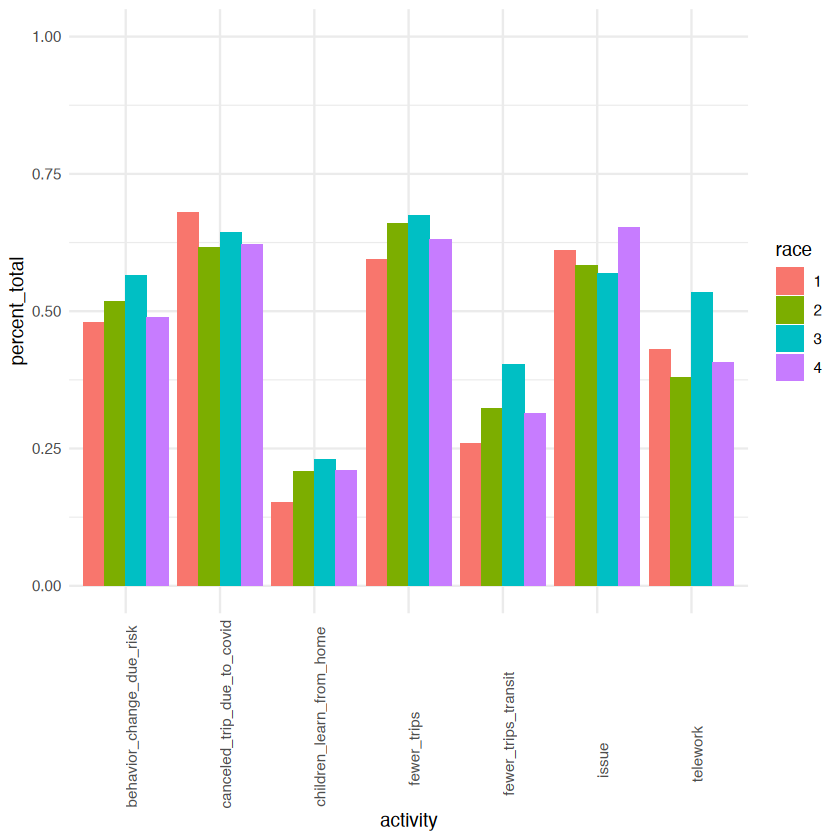

In [17]:
df2 <- group_by(df_mod, race) %>% 
  summarise(across(everything(), sum), total_each_race = n()) %>%
  pivot_longer(-c(race,total_each_race), names_to = "activity", values_to = "total_people") %>%
  mutate(percent_total = (total_people/total_each_race))

ggplot(df2, aes(x = activity, y = percent_total, fill = race)) + 
  geom_bar(position="dodge", stat="identity") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, hjust=.2)) +
  ylim(c(0,1))


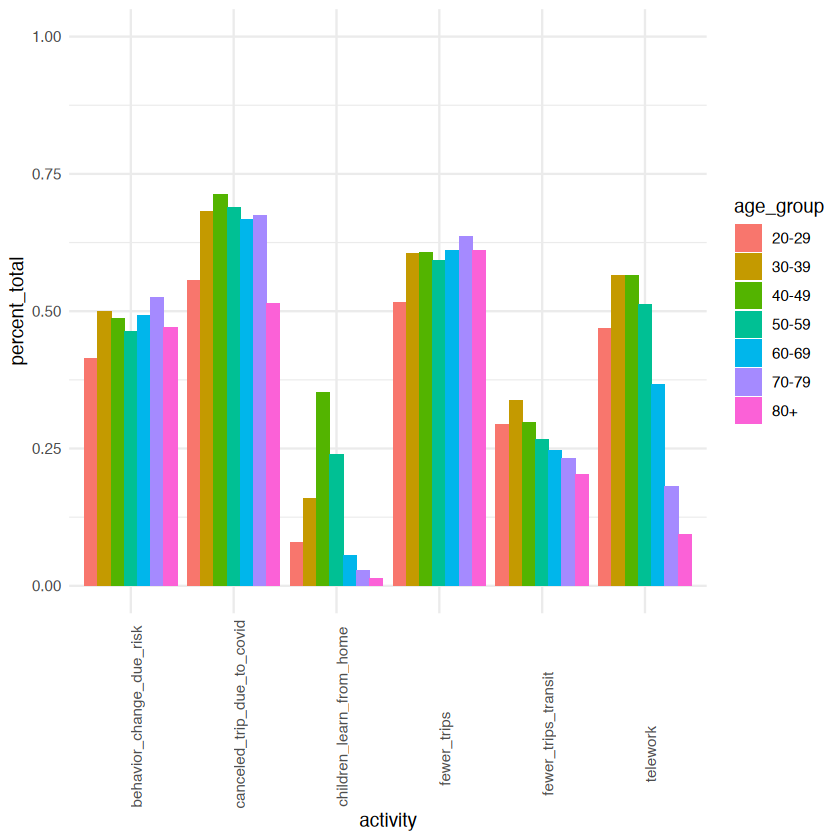

In [18]:
df_mod <- select(df, age_group, telework,fewer_trips,fewer_trips_transit,children_learn_from_home,
                 behavior_change_due_risk,canceled_trip_due_to_covid)

df3 <- group_by(df_mod, age_group) %>% 
  summarise(across(everything(), sum), total_each_age_group = n()) %>%
  pivot_longer(-c(age_group,total_each_age_group), names_to = "activity", values_to = "total_people") %>%
  mutate(percent_total = (total_people/total_each_age_group))

ggplot(df3, aes(x = activity, y = percent_total, fill = age_group)) + 
  geom_bar(position="dodge", stat="identity") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, hjust=.2)) +
  ylim(c(0,1))

In [19]:
mod.fit <- glm(issue ~ telework + fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid + age, family = binomial, data=df)

mod.fit_age <- glm(issue ~ (telework + fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid)*age_group, family = binomial, data=df)

lrtest(mod.fit, mod.fit_age)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-50869.05,NA,NA,NA
2,49,-50688.60,41,360.8859,8.906314e-53


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 13 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13].”




|                                              | Estimate| Std..Error| z.value| Pr...z..|
|:---------------------------------------------|--------:|----------:|-------:|--------:|
|age_group30-39                                |  0.22900|     0.0755|  3.0300| 2.46e-03|
|age_group40-49                                |  0.22800|     0.0732|  3.1200| 1.81e-03|
|age_group50-59                                |  0.28600|     0.0728|  3.9400| 8.27e-05|
|age_group60-69                                |  0.20600|     0.0716|  2.8800| 4.02e-03|
|age_group70-79                                |  0.10500|     0.0744|  1.4100| 1.58e-01|
|age_group80+                                  | -0.00629|     0.0899| -0.0699| 9.44e-01|
|teleworkTRUE:age_group30-39                   | -0.03220|     0.0840| -0.3840| 7.01e-01|
|teleworkTRUE:age_group40-49                   | -0.09420|     0.0811| -1.1600| 2.45e-01|
|teleworkTRUE:age_group50-59                   | -0.18000|     0.0812| -2.2200| 2.63e-02|
|telewor

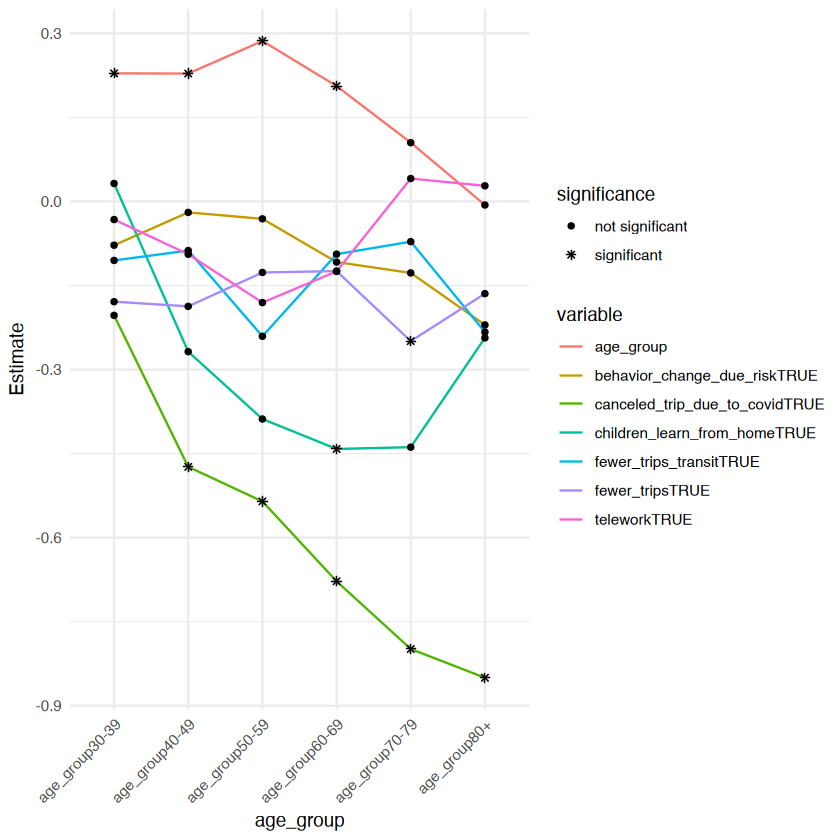

In [20]:
df_summary <- summary(mod.fit_age)$coefficients %>% 
  data.frame()

df_summary$variables <- rownames(df_summary)
df_summary <- separate(df_summary, variables, into = c('variable', 'age_group'), sep = ":", remove = FALSE) %>%
  #mutate(age_group = replace_na(age_group, "age_group"))
  mutate(age_group = coalesce(age_group, variable)) %>%
  mutate(significance = ifelse(Pr...z.. < 0.01, "significant", "not significant"))

age_groups <- df_summary$age_group %>% unique()
age_groups <- age_groups[8:length(age_groups)]

df_summary <- mutate(df_summary, variable = ifelse(variable %in% age_groups, "age_group", variable))

#df_summary <- df_summary[df_summary[9:14,6] = "age_group"]
df_summary <- df_summary[8:nrow(df_summary),]

ggplot(df_summary, aes(x= age_group, y = Estimate, group=variable)) +
  geom_line(aes(color = variable)) +
  geom_point(aes(shape = significance)) +
  scale_size_manual(values=c(10,1)) +
  scale_shape_manual(values=c(16, 8)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

df_summary[,1:4] %>% signif(3) %>% kable

In [21]:
df_young <- filter(df, age < 60)

mod.fit_young_interaction <- glm(issue ~ (telework + fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid)*age_group, family = binomial, data=df_young)
mod.fit_young_interaction$aic

mod.fit_young <- glm(issue ~ telework + fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid + age_group, family = binomial, data=df_young)
mod.fit_young$aic

mod.fit_young_cont <- glm(issue ~ telework + fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid + age, family = binomial, data=df_young)
mod.fit_young_cont$aic

lrtest(mod.fit_young_cont, mod.fit_young)

[1] 58322.36

[1] 58444.72

[1] 58458.39

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,-29221.19,NA,NA,NA
2,10,-29212.36,2,17.66779,0.0001457093


In [22]:
mod.fit_no_age <- glm(issue ~ telework + fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid, family = binomial, data=df_young)
mod.fit_no_age$aic

a <- anova(mod.fit_young_interaction, mod.fit_young)
lrtest(mod.fit_young_interaction, mod.fit_young)
lrtest(mod.fit_no_age, mod.fit_young)

[1] 58568.96

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,28,-29133.18,NA,NA,NA
2,10,-29212.36,-18,158.3613,1.743039e-24


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,-29277.48,NA,NA,NA
2,10,-29212.36,3,130.2359,4.811042e-28


In [23]:
hoslemv2(df_young$issue, mod.fit_young_cont$fitted.values)
hoslemv2(df_young$issue, mod.fit_young$fitted.values)

Hosmer-Lemeshow test with 10 bins 
 Pearson Stat =  320.5897 
 p =  0 
 


,obs.o,pred.o,avg mean,pearson resid
,<dbl>,<dbl>,<dbl>,<dbl>
"[0.225,0.282]",958,1416.399,0.2586085,-12.1800908
"(0.282,0.436]",1679,1837.561,0.3501449,-3.6989137
"(0.436,0.5]",2969,2490.504,0.4656017,9.5881561
"(0.5,0.641]",3466,3126.606,0.5831045,6.0696957
"(0.641,0.691]",3824,3587.311,0.6654258,3.9517920
"(0.691,0.779]",3889,3859.133,0.7255372,0.4807863
"(0.779,0.818]",4255,4312.041,0.8014946,-0.8686523
"(0.818,0.847]",4404,4528.310,0.8328693,-1.8473055
"(0.847,0.881]",4458,4546.809,0.8608119,-1.3170469


Hosmer-Lemeshow test with 10 bins 
 Pearson Stat =  299.4712 
 p =  0 
 


,obs.o,pred.o,avg mean,pearson resid
,<dbl>,<dbl>,<dbl>,<dbl>
"[0.235,0.283]",951,1397.760,0.2569884,-11.9497205
"(0.283,0.431]",1838,1961.130,0.3544425,-2.7804259
"(0.431,0.508]",2941,2462.960,0.4678875,9.6324323
"(0.508,0.639]",3385,3078.002,0.5861744,5.5335239
"(0.639,0.695]",3889,3683.541,0.6668249,3.3852640
"(0.695,0.779]",3966,3923.067,0.7300087,0.6854553
"(0.779,0.819]",4568,4640.111,0.8026485,-1.0586102
"(0.819,0.842]",3939,4018.116,0.8357146,-1.2481063
"(0.842,0.882]",4615,4736.819,0.8626514,-1.7699900


[1] 1.05526e-47

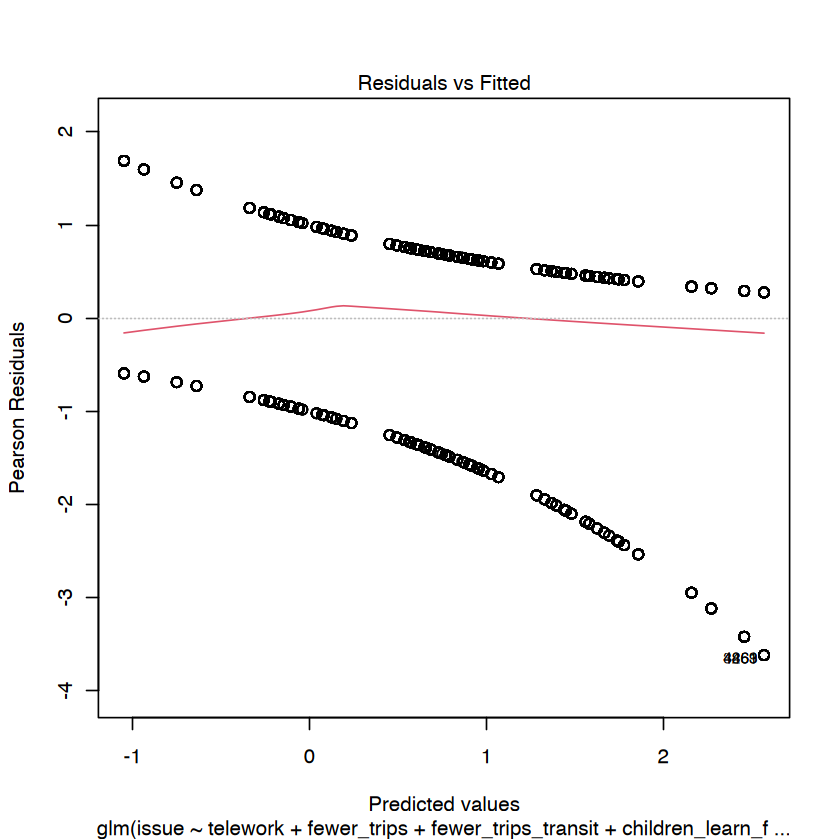

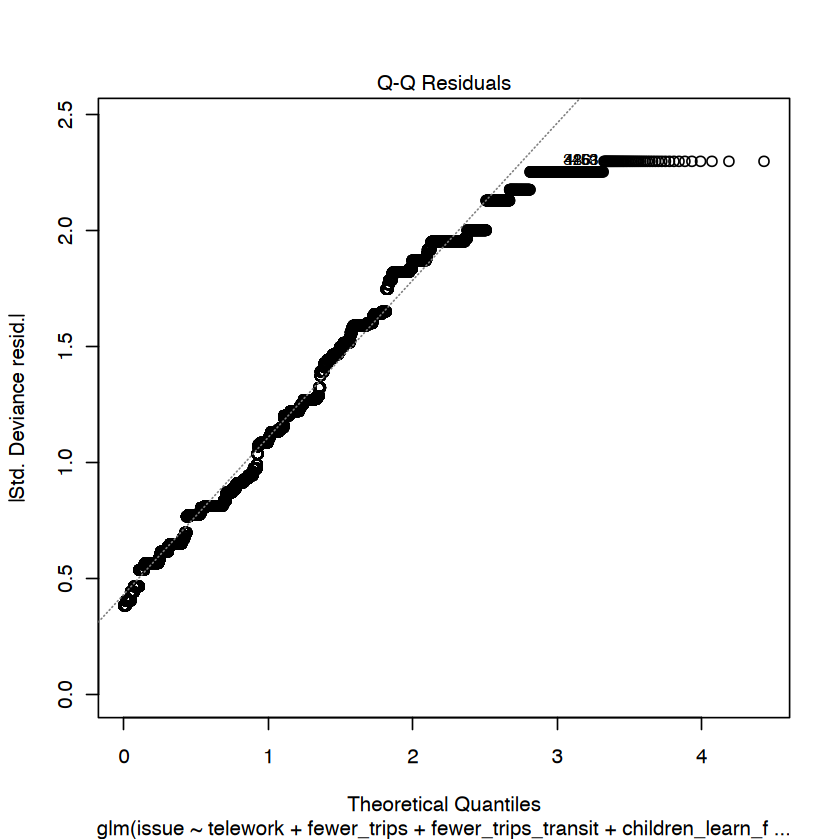

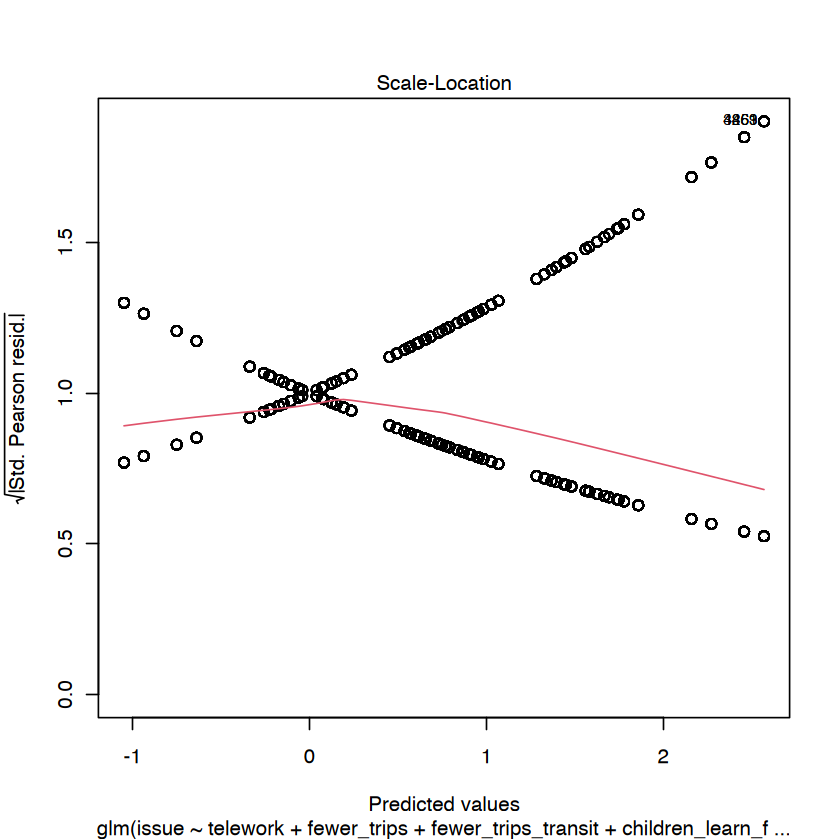

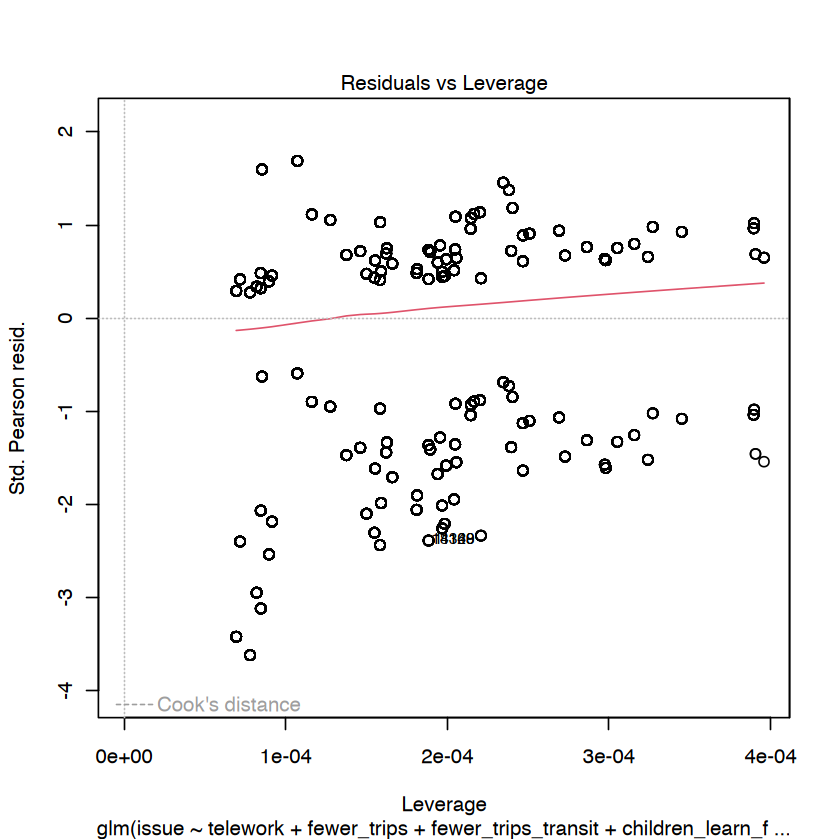

In [24]:
pchisq(mod.fit_young_cont$deviance, mod.fit_young_cont$df.residual, lower.tail = F)
plot(mod.fit_no_age)

In [25]:
df_young_agg_all_var_no_age <- group_by(df_young, issue, telework, fewer_trips, fewer_trips_transit, children_learn_from_home, behavior_change_due_risk, canceled_trip_due_to_covid) %>%
  summarize(n = n(), total_w_issue = sum(issue)) %>%
  mutate(RR = total_w_issue/n)

mod.fit_young_cont_agg_no_age <- glm(issue/n ~ fewer_trips + fewer_trips_transit + telework + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid, family = binomial, data=df_young_agg_all_var_no_age, weights = n)

`summarise()` has grouped output by 'issue', 'telework', 'fewer_trips',
'fewer_trips_transit', 'children_learn_from_home', 'behavior_change_due_risk'.
You can override using the `.groups` argument.


[1] 0.9874209

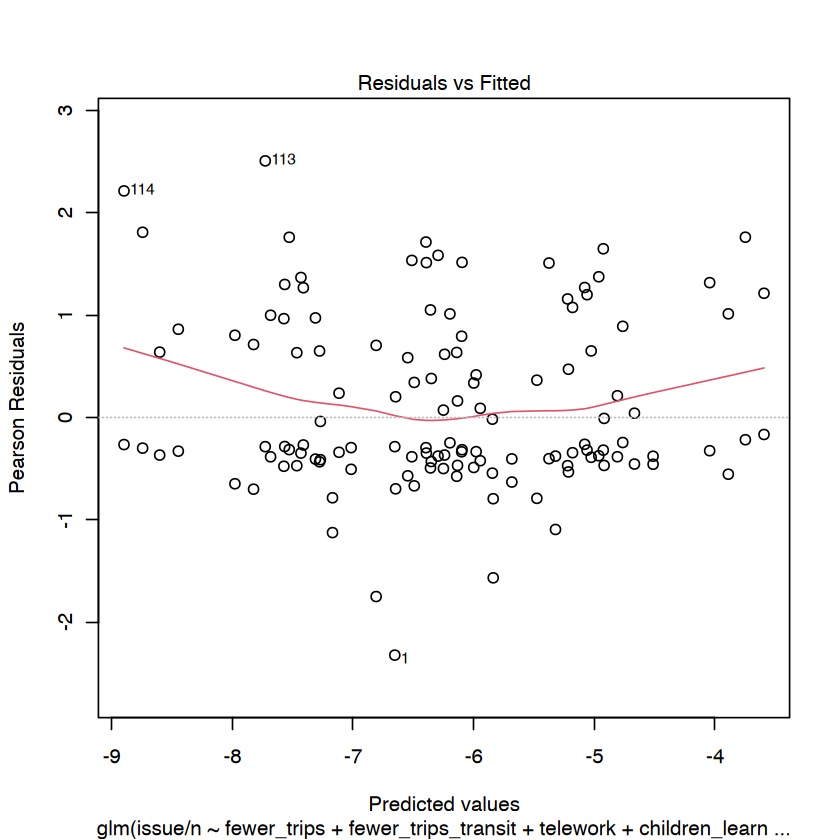

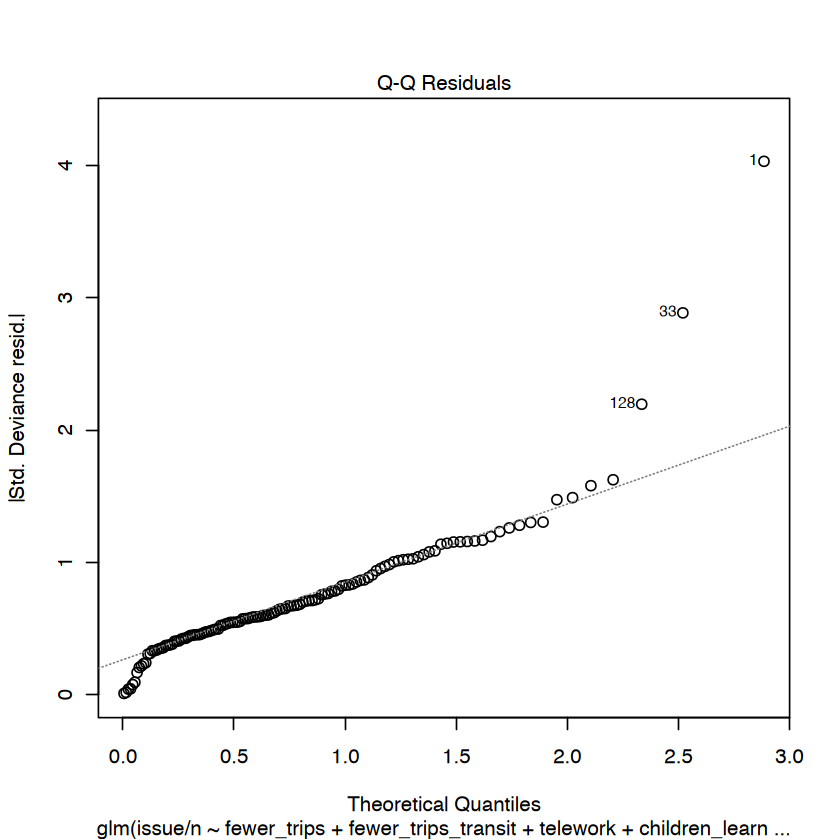

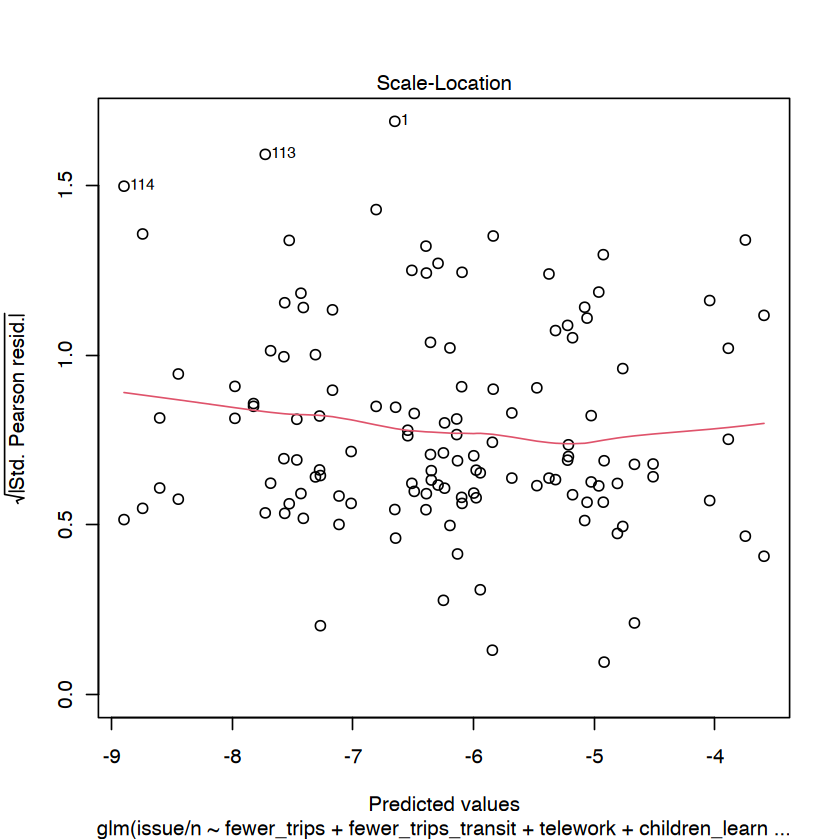

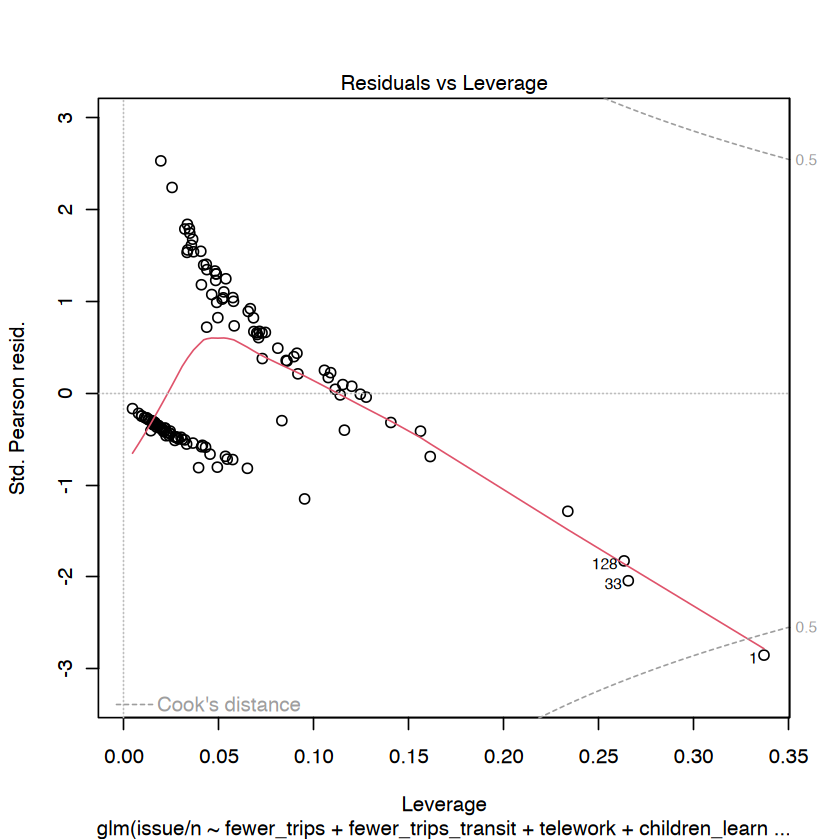

In [26]:
pchisq(mod.fit_young_cont_agg_no_age$deviance, mod.fit_young_cont_agg_no_age$df.residual, lower.tail = F)
plot(mod.fit_young_cont_agg_no_age)

In [27]:
mod.fit_young_cont_agg_no_age$aic

[1] 230.2064

`summarise()` has grouped output by 'issue', 'fewer_trips',
'fewer_trips_transit', 'children_learn_from_home', 'behavior_change_due_risk'.
You can override using the `.groups` argument.


[1] 0

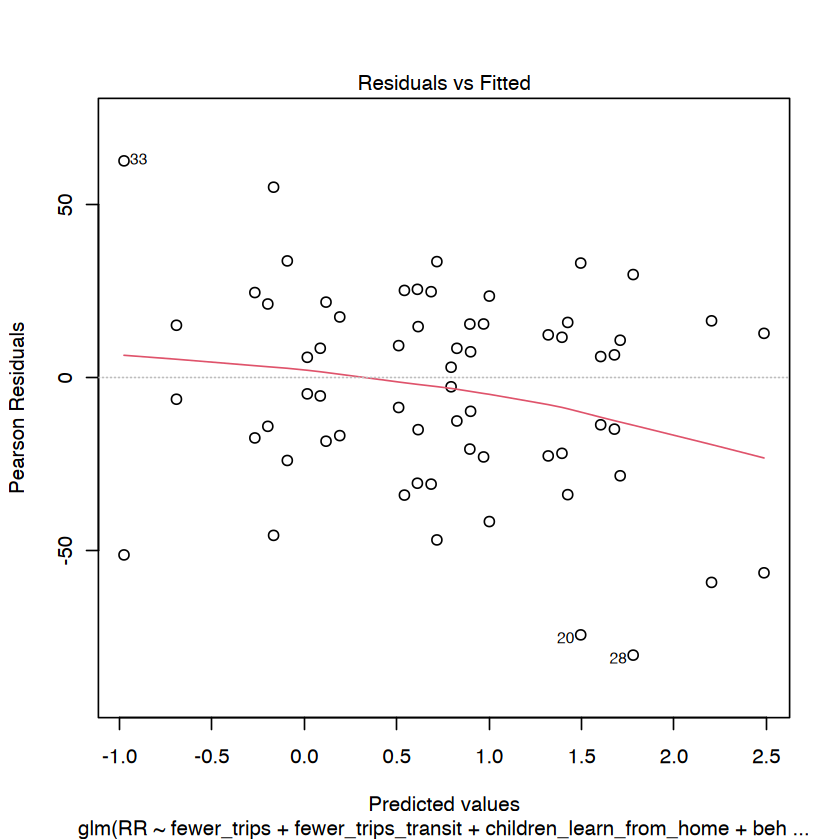

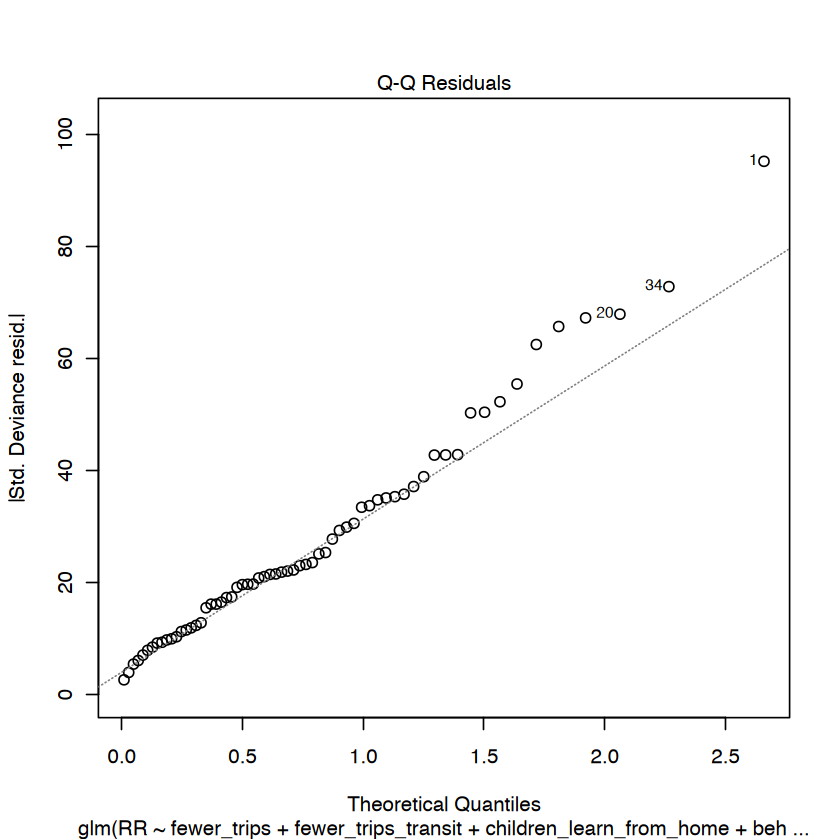

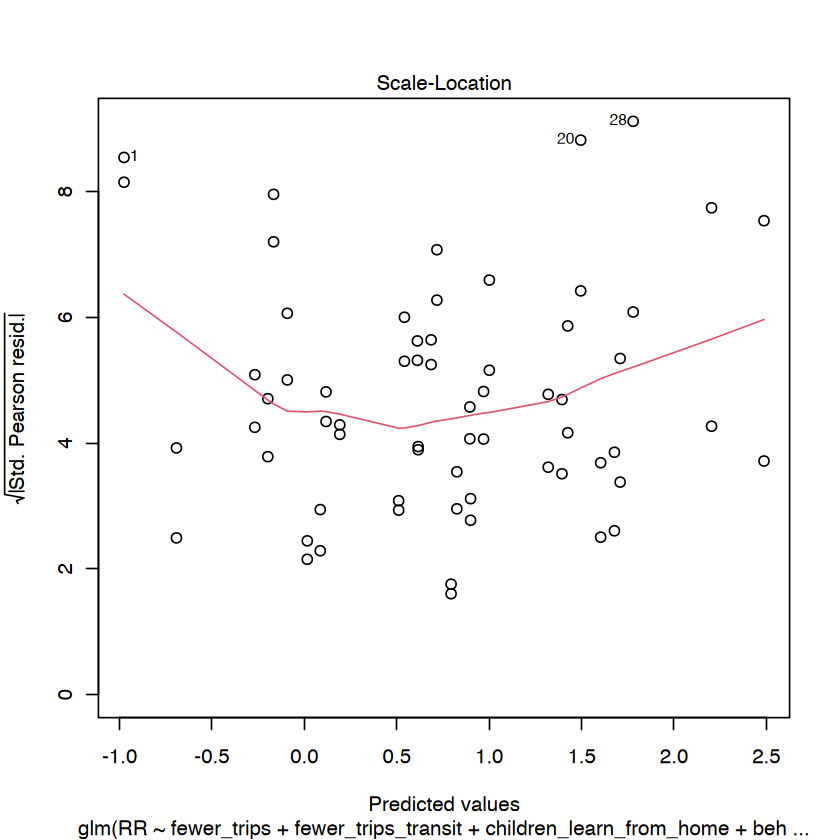

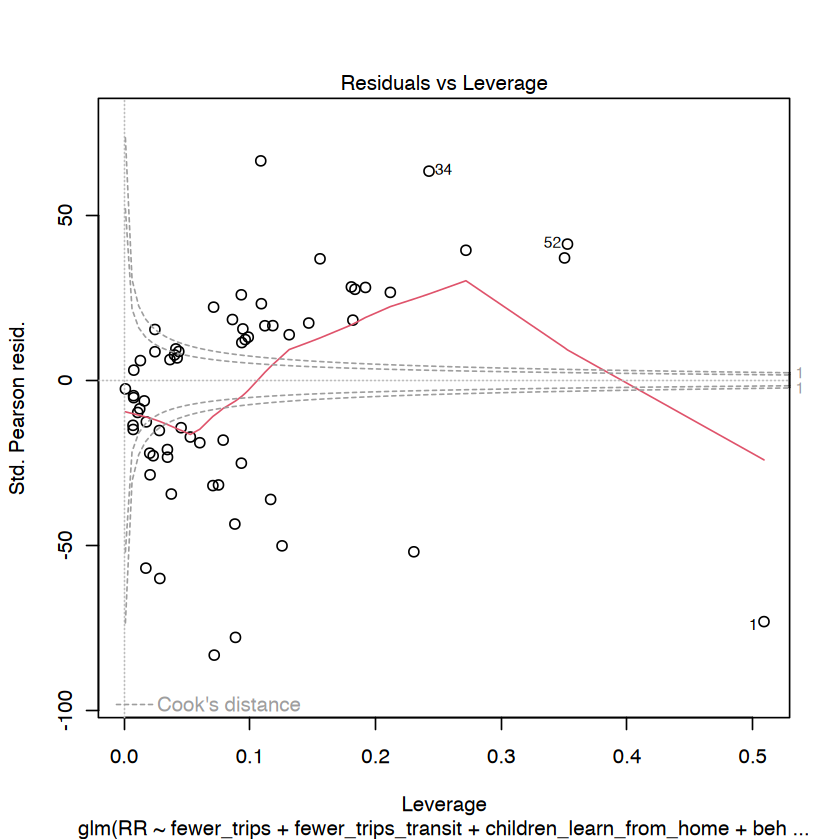

In [28]:
df_young_agg_all_var_no_age_no_tele <- group_by(df_young, issue, fewer_trips, fewer_trips_transit, children_learn_from_home, behavior_change_due_risk, canceled_trip_due_to_covid)  %>%
  summarize(n = n(), total_w_issue = sum(issue)) %>%
  mutate(RR = total_w_issue/n)

mod.fit_young_cont_agg_no_age_no_tele <- glm(RR ~ fewer_trips + fewer_trips_transit + children_learn_from_home + behavior_change_due_risk + canceled_trip_due_to_covid, family = binomial, data=df_young_agg_all_var_no_age_no_tele, weights = n)

pchisq(mod.fit_young_cont_agg_no_age_no_tele$deviance, mod.fit_young_cont_agg_no_age_no_tele$df.residual, lower.tail = F)
plot(mod.fit_young_cont_agg_no_age_no_tele)

In [29]:
mod.fit_young_cont_agg_no_age_no_tele$aic

[1] 58595.41

In [30]:
df_agg <- group_by(df_young, fewer_trips, fewer_trips_transit, children_learn_from_home, canceled_trip_due_to_covid) %>%
  summarize(n = n(), total_w_issue = sum(issue)) %>%
  mutate(RR = total_w_issue/n)

mod.fit_young_cont_agg_no_age_no_tele_no_behave <- glm(RR ~ fewer_trips + fewer_trips_transit + children_learn_from_home + canceled_trip_due_to_covid, family = binomial, data=df_agg, weights = n)


`summarise()` has grouped output by 'fewer_trips', 'fewer_trips_transit',
'children_learn_from_home'. You can override using the `.groups` argument.


[1] 1.361475e-212

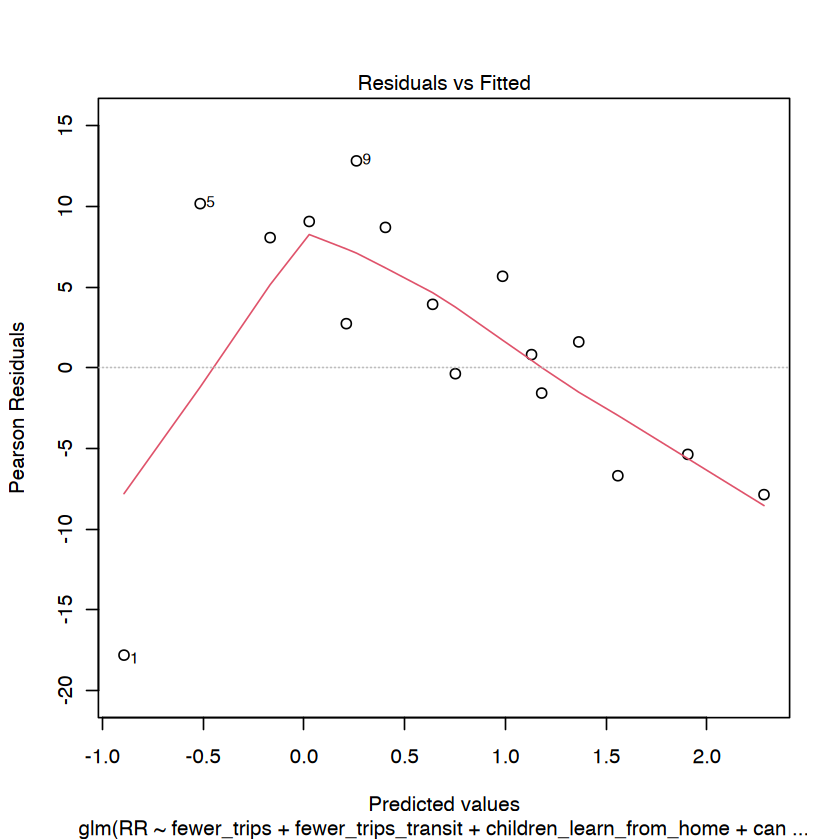

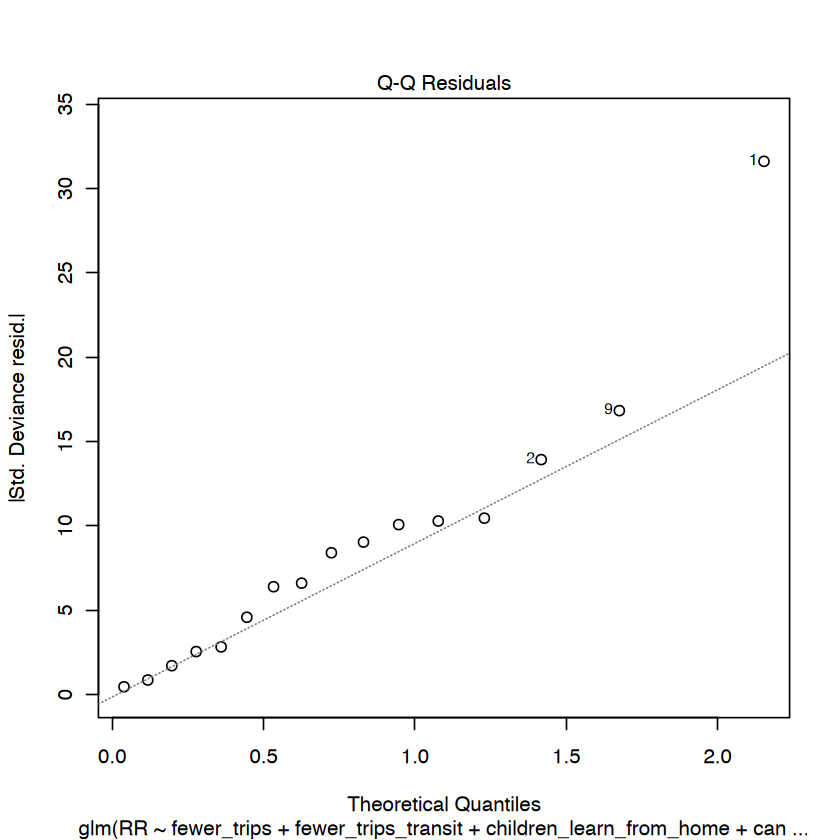

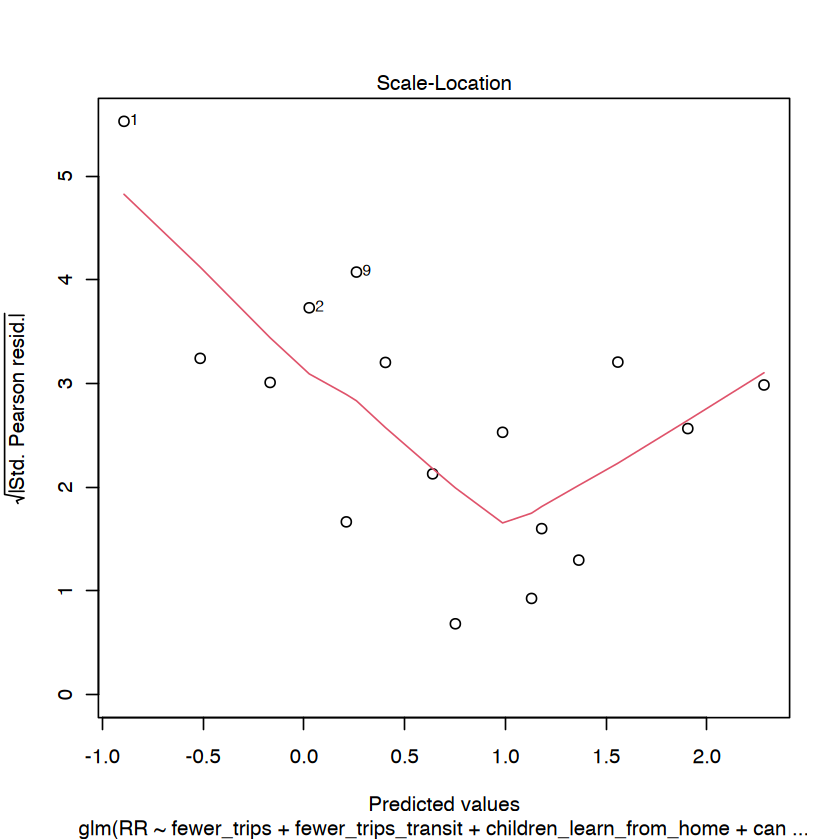

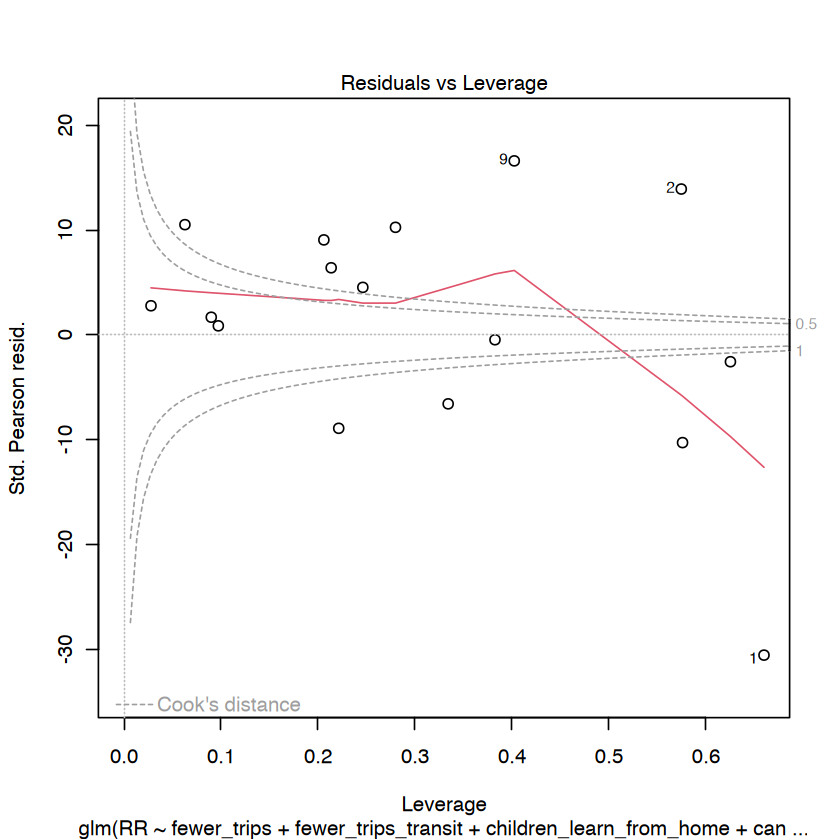

In [31]:
pchisq(mod.fit_young_cont_agg_no_age_no_tele_no_behave$deviance, mod.fit_young_cont_agg_no_age_no_tele_no_behave$df.residual, lower.tail = F)
plot(mod.fit_young_cont_agg_no_age_no_tele_no_behave)

In [32]:
png(filename="/Users/kevin_li/Desktop/testpic.png")
influencePlot(mod.fit_young_cont_agg_no_age_no_tele_no_behave)
dev.off()

,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
1,-30.913176,0.6598928,362.137748
2,13.918431,0.5746086,52.267531
9,16.738271,0.4023860,37.091446
10,-2.558753,0.6252868,2.190481


pdf 
  2

In [33]:
print(mod.fit_young_cont_agg_no_age_no_tele_no_behave$aic) %>% round(2)

[1] 1155.763


[1] 1155.76

In [34]:
expit <- function(x){
  exp(x) /  ( 1 + exp(x))
}

In [35]:
mod.final <- mod.fit_young_cont_agg_no_age_no_tele_no_behave
summary(mod.final)


Call:
glm(formula = RR ~ fewer_trips + fewer_trips_transit + children_learn_from_home + 
    canceled_trip_due_to_covid, family = binomial, data = df_agg, 
    weights = n)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -0.89242    0.01881  -47.45   <2e-16 ***
fewer_tripsTRUE                 1.15360    0.02104   54.83   <2e-16 ***
fewer_trips_transitTRUE         0.37811    0.02464   15.34   <2e-16 ***
children_learn_from_homeTRUE    0.72524    0.02531   28.65   <2e-16 ***
canceled_trip_due_to_covidTRUE  0.91927    0.02131   43.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 10978.9  on 15  degrees of freedom
Residual deviance:  1023.9  on 11  degrees of freedom
AIC: 1155.8

Number of Fisher Scoring iterations: 4


In [36]:
df_coef_final <- cbind(summary(mod.final)$coefficients[,1:2] %>% round(2), `p-value` = formatC(summary(mod.final)$coefficients[,4], format = "e", digits = 2))

rownames(df_coef_final) <- c("Intercept", "Fewer Trips to Store", "Fewer Trips on Transit", "Remote Learning", "Canceled Vacation")
kable(df_coef_final)



|                       |Estimate |Std. Error |p-value   |
|:----------------------|:--------|:----------|:---------|
|Intercept              |-0.89    |0.02       |0.00e+00  |
|Fewer Trips to Store   |1.15     |0.02       |0.00e+00  |
|Fewer Trips on Transit |0.38     |0.02       |3.94e-53  |
|Remote Learning        |0.73     |0.03       |1.41e-180 |
|Canceled Vacation      |0.92     |0.02       |0.00e+00  |

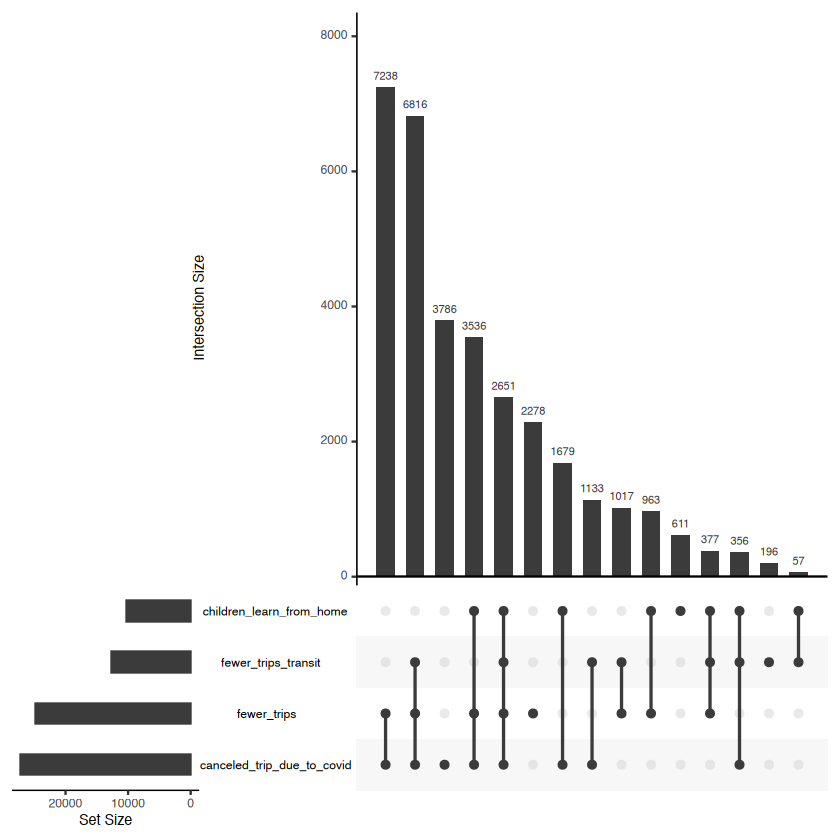

In [37]:
df_upset_1 <- filter(df_young, issue ==1) %>%
  select(fewer_trips, fewer_trips_transit, children_learn_from_home, canceled_trip_due_to_covid)
cols <- sapply(df_upset_1, is.logical)
df_upset_1[,cols] <- lapply(df_upset_1[,cols], as.numeric)
  #t() %>% 
  #data.frame()
#issue, fewer_trips, fewer_trips_transit, children_learn_from_home, canceled_trip_due_to_covid
upset(df_upset_1, nset=ncol(df_upset_1), order.by="freq")

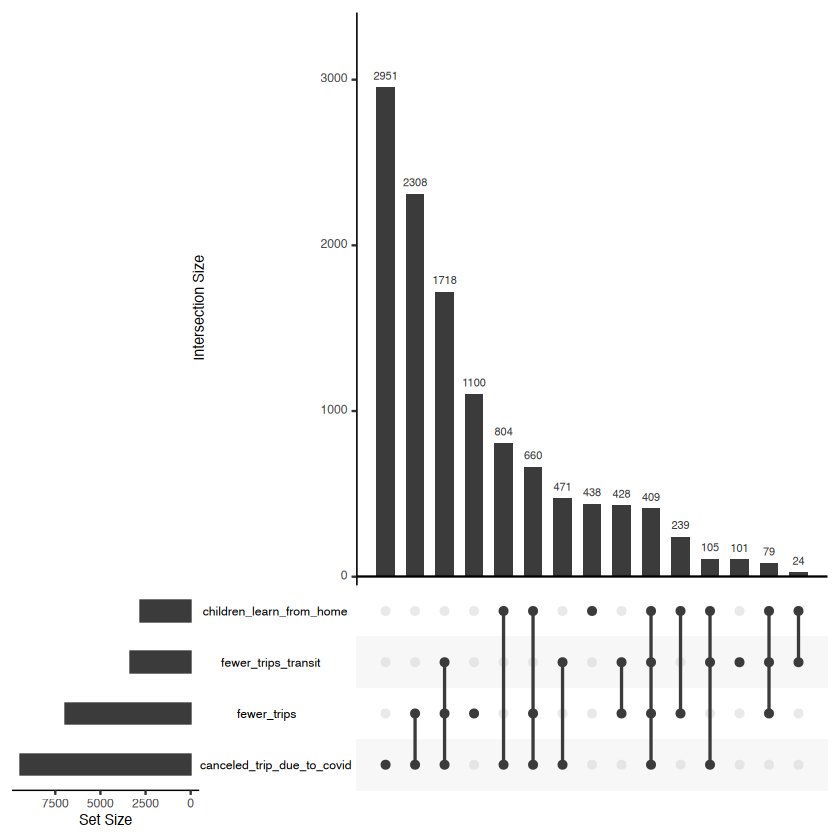

In [38]:
df_upset_0 <- filter(df_young, issue ==0) %>%
  select(fewer_trips, fewer_trips_transit, children_learn_from_home, canceled_trip_due_to_covid)
cols <- sapply(df_upset_0, is.logical)
df_upset_0[,cols] <- lapply(df_upset_0[,cols], as.numeric)
  #t() %>% 
  #data.frame()
#issue, fewer_trips, fewer_trips_transit, children_learn_from_home, canceled_trip_due_to_covid
upset(df_upset_0, nset=ncol(df_upset_0), order.by="freq")

In [39]:
mod.final$fitted.values

1         2         3         4         5         6         7         8 
0.2906102 0.5067124 0.4583003 0.6796332 0.3741828 0.5998787 0.5525357 0.7558749 
        9        10        11        12        13        14        15        16 
0.5649253 0.7650287 0.7283785 0.8705336 0.6545917 0.8261464 0.7964933 0.9075259

In [40]:
1-pchisq(1,11)

[1] 0.9999496

In [41]:
exp(cbind(summary(mod.final)$coefficients[,1:2] %>% round(2), `p-value` = formatC(summary(mod.final)$coefficients[,4], format = "e", digits = 2)))

ERROR: Error in exp(cbind(summary(mod.final)$coefficients[, 1:2] %>% round(2), : non-numeric argument to mathematical function


In [42]:
round(exp(cbind(mod.final$coefficients, confint(mod.final))),3)

Waiting for profiling to be done...



,,2.5 %,97.5 %
(Intercept),0.410,0.395,0.425
fewer_tripsTRUE,3.170,3.042,3.303
fewer_trips_transitTRUE,1.460,1.391,1.532
children_learn_from_homeTRUE,2.065,1.965,2.171
canceled_trip_due_to_covidTRUE,2.507,2.405,2.614


In [44]:
summary(mod.final)$coefficients[,4]

(Intercept)                fewer_tripsTRUE 
                  0.000000e+00                   0.000000e+00 
       fewer_trips_transitTRUE   children_learn_from_homeTRUE 
                  3.939746e-53                  1.410129e-180 
canceled_trip_due_to_covidTRUE 
                  0.000000e+00